In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def deltaQ(P, masses, timeStepSize):
    return np.array([(timeStepSize * (P[i] / masses[i])).tolist() for i in range(len(masses))])

def deltaP(Q, masses, timeStepSize):
    # Hack steal dimension/structure of Q (as python is a little b**** and wont tell me)
    P = np.copy(Q)
    P[:] = 0
    
    numObjs = len(masses)
    
    for i in range(numObjs):
        for j in range(i):
            interObjDir = Q[j] - Q[i]
            interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
            delta = (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
            P[i] += timeStepSize * delta
            P[j] -= timeStepSize * delta
    
    return P

In [3]:
#----------------------------------------------------------------------------------------------
def explicitEuler(oldQ, oldP, masses, timeStepSize):
    numObjs = len(masses)
    newQ = oldQ
    newP = oldP
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = oldQ[j] - oldQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += timeStepSize * deltaP
        newQ[i] += timeStepSize * (oldP[i] / masses[i])
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerA(oldQ, oldP, masses, timeStepSize):
    numObjs = len(masses)
    newQ = oldQ
    newP = oldP
    for i in range(numObjs):
        newQ[i] += timeStepSize * (oldP[i] / masses[i])
        
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = newQ[j] - newQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += timeStepSize * deltaP
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerB(oldQ, oldP, masses, timeStepSize):
    numObjs = len(masses)
    newQ = oldQ
    newP = oldP
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = oldQ[j] - oldQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += timeStepSize * deltaP
        newQ[i] += timeStepSize * (newP[i] / masses[i])
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerAB(oldQ, oldP, masses, timeStepSize):
    newQA, newPA = symplecticEulerA(oldQ, oldP, masses, timeStepSize)
    newQB, newPB = symplecticEulerB(oldQ, oldP, masses, timeStepSize)
    newQ = (newQA + newQB) / 2.0
    newP = (newPA + newPB) / 2.0
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def stormerVerletA(oldQ, oldP, masses, timeStepSize):
    newQ = oldQ
    newP = oldP
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = oldQ[j] - oldQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += (timeStepSize/2) * deltaP
        newQ[i] += timeStepSize * (newP[i] / masses[i])
        
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = newQ[j] - newQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += (timeStepSize/2) * deltaP
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def stormerVerletB(oldQ, oldP, masses, timeStepSize):
    newQ = oldQ
    newP = oldP
    
    for i in range(numObjs):
        newQ[i] += (timeStepSize/2) * (oldP[i] / masses[i])
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = newQ[j] - newQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += timeStepSize * deltaP
        
    for i in range(numObjs):
        newQ[i] += (timeStepSize/2) * (newP[i] / masses[i])
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def midPoint(oldQ, oldP, masses, timeStepSize):
    newQEst, newPEst = explicitEuler(oldQ, oldP, masses, timeStepSize)
    
    midQ = (oldQ + newQEst) / 2.0
    midP = (oldP + newPEst) / 2.0
    
    newQ = oldQ
    newP = oldP
    
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = midQ[j] - midQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += timeStepSize * deltaP
        newQ[i] += timeStepSize * (midP[i] / masses[i])
    
    return newQ, newP
#----------------------------------------------------------------------------------------------

In [4]:
masses = [1.00000597682, 9.54786104043e-4, 2.85583733151e-4, 4.37273164546e-5, 5.17759138449e-5, 1/(1.3e8)]
q = np.array(
    [[0,0,0],
    [-3.5023653,-3.8169847,-1.5507963],
    [9.0755314,-3.0458353,-1.6483708],
    [8.3101420, -16.2901086, -7.2521278],
    [11.4707666, -25.7294829, -10.8169456],
    [-15.5387357, -25.2225594, -3.1902382]])
v = np.array(
    [[0,0,0],
    [0.00565429, -0.00412490, -0.0019058],
    [0.00168318, 0.00483525, 0.00192462],
    [0.00354178, 0.00137102, 0.00055029],
    [0.00288930, 0.00114527, 0.00039677],
    [0.00276725, -0.00170702, -0.00136504]])

p = np.array([(masses[i]*v[i]).tolist() for i in range(len(masses))])
totMomentum = sum(p)
totMass = sum(masses)
deltaV = -1/totMass * totMomentum

# print(p)
# print(totMomentum)
# print(totMass)
# print(deltaV)

In [5]:
numberTimeSteps = 20000
timeStepSize = 25.0
updateFn = explicitEuler

names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
numObjs = len(names)
masses = [1.00000597682, 9.54786104043e-4, 2.85583733151e-4, 4.37273164546e-5, 5.17759138449e-5, 1/(1.3e8)]
q = np.array(
    [[0,0,0],
    [-3.5023653,-3.8169847,-1.5507963],
    [9.0755314,-3.0458353,-1.6483708],
    [8.3101420, -16.2901086, -7.2521278],
    [11.4707666, -25.7294829, -10.8169456],
    [-15.5387357, -25.2225594, -3.1902382]])
v = np.array(
    [[0,0,0],
    [0.00565429, -0.00412490, -0.0019058],
    [0.00168318, 0.00483525, 0.00192462],
    [0.00354178, 0.00137102, 0.00055029],
    [0.00288930, 0.00114527, 0.00039677],
    [0.00276725, -0.00170702, -0.00136504]])
p = np.array([(masses[i]*(v[i] + deltaV)).tolist() for i in range(numObjs)])

qStored = np.empty((numberTimeSteps,numObjs,3))
qStored[:] = np.nan
pStored = np.empty((numberTimeSteps,numObjs,3))
pStored[:] = np.nan

for i in range(numberTimeSteps):
    q, p = updateFn(q, p, masses, timeStepSize)
    
    qStored[i] = q
    pStored[i] = p
    
    if ((i+1)%int(numberTimeSteps/100) == 0):
        print("{}% has been completed".format((i+1)*100/numberTimeSteps), end = "\r")

<IPython.core.display.Javascript object>


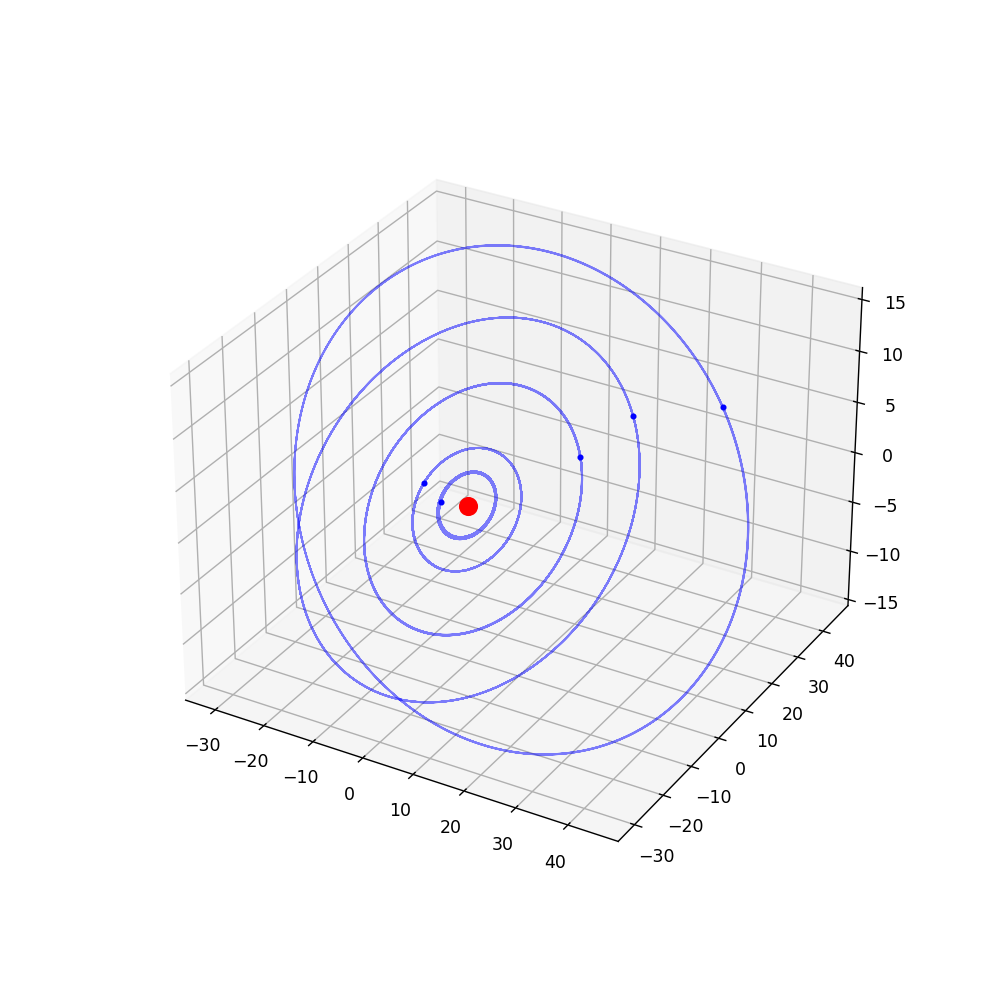

<IPython.core.display.Javascript object>


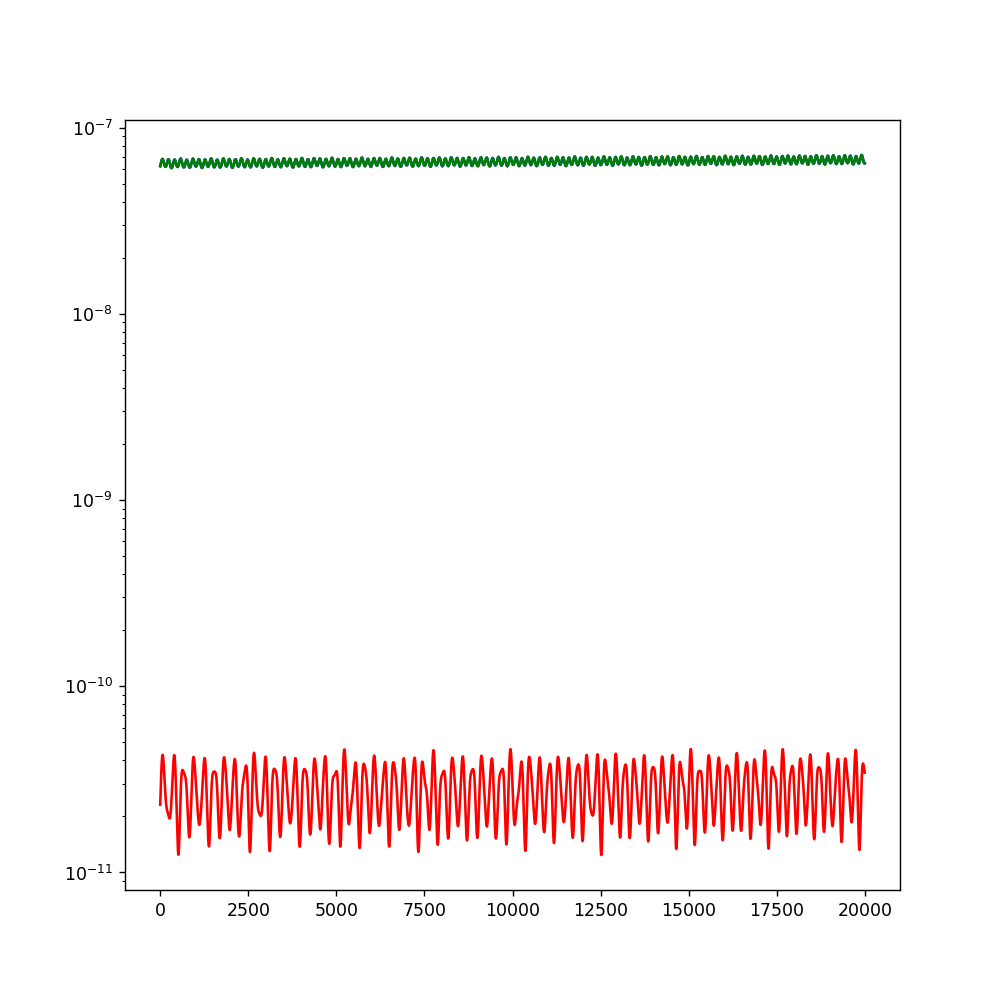

<IPython.core.display.Javascript object>


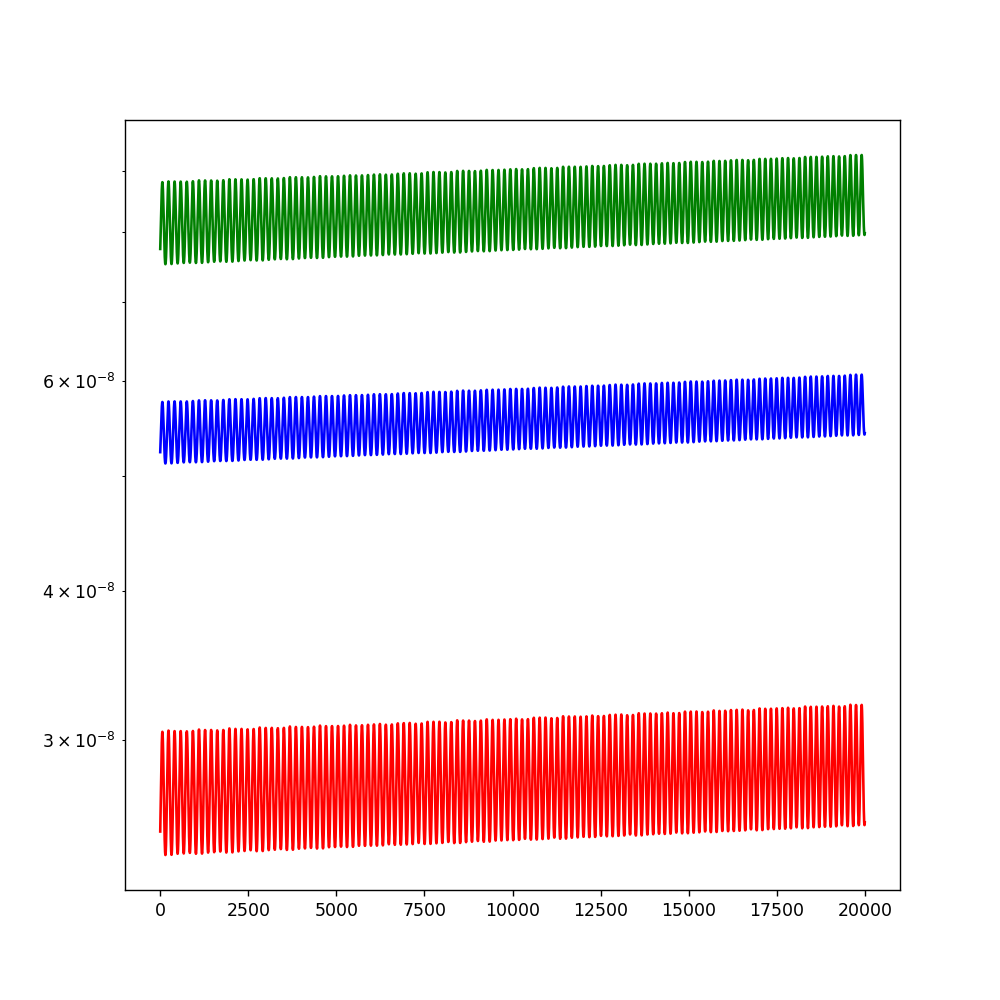

<IPython.core.display.Javascript object>


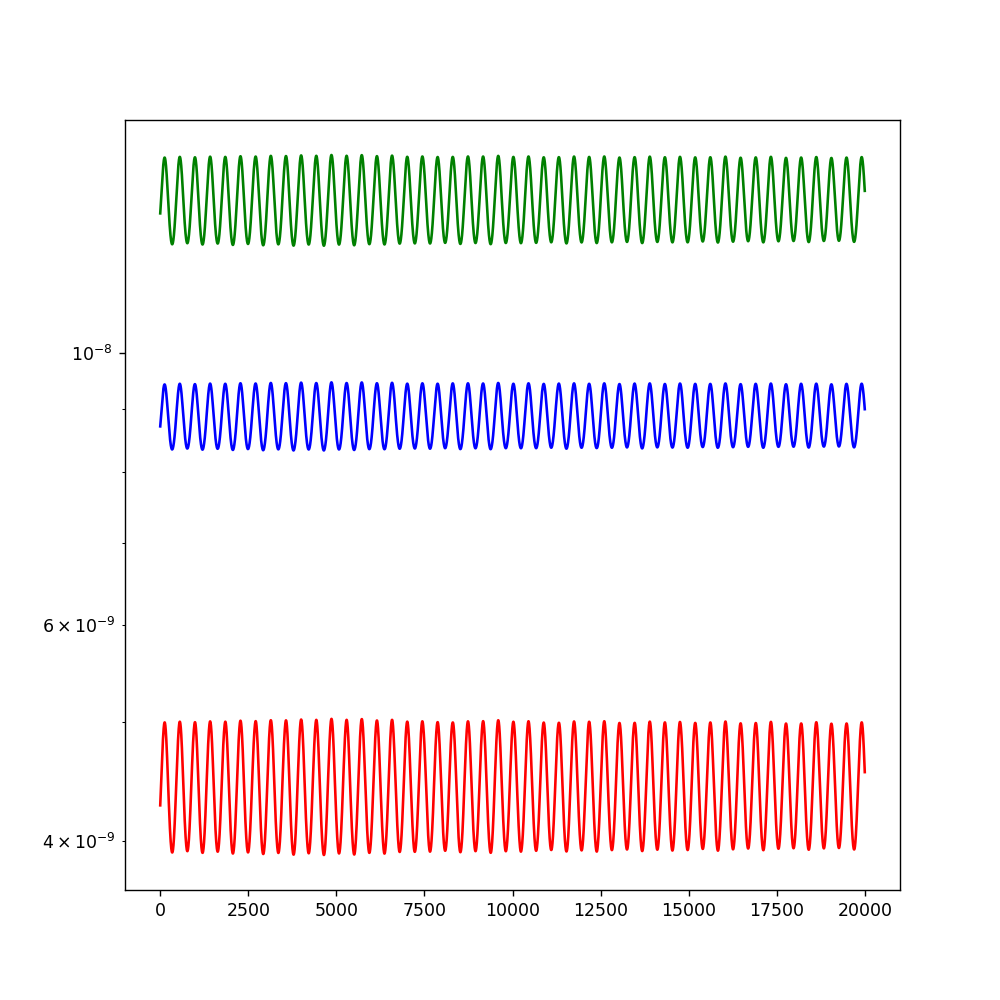

<IPython.core.display.Javascript object>


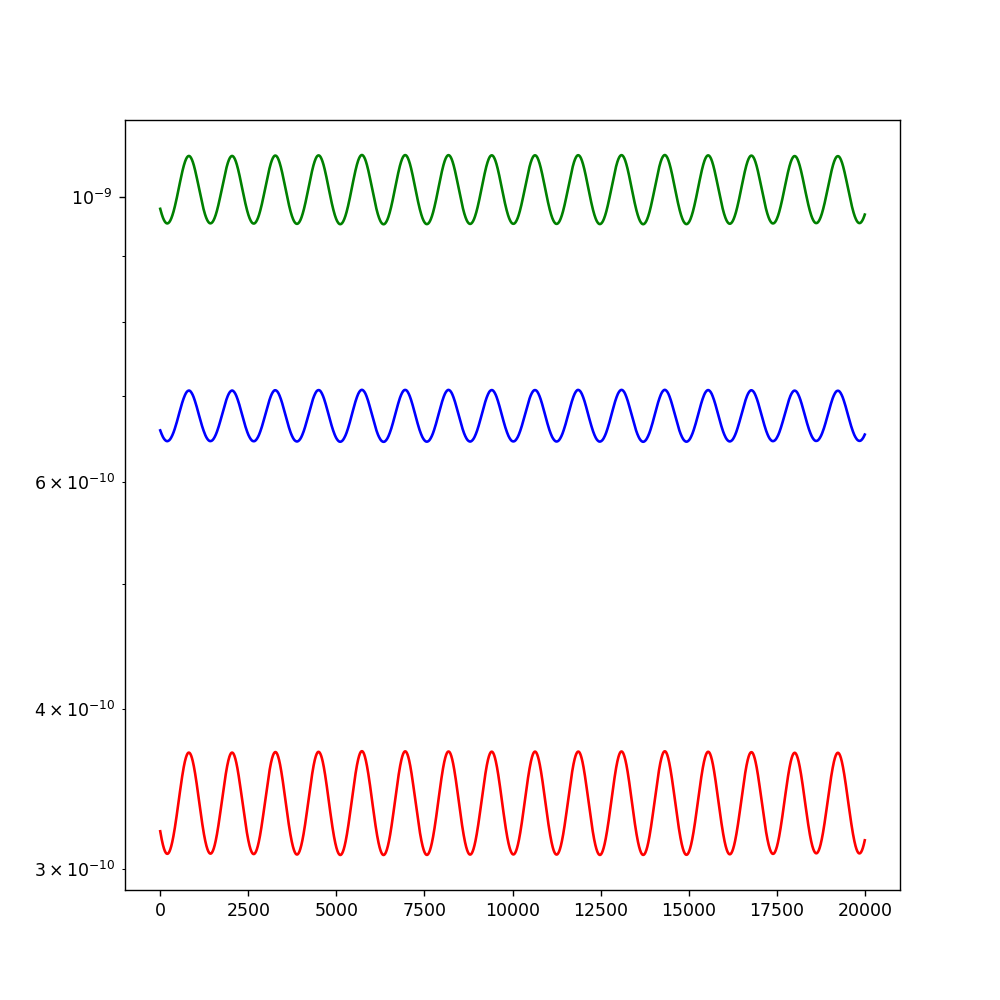

<IPython.core.display.Javascript object>


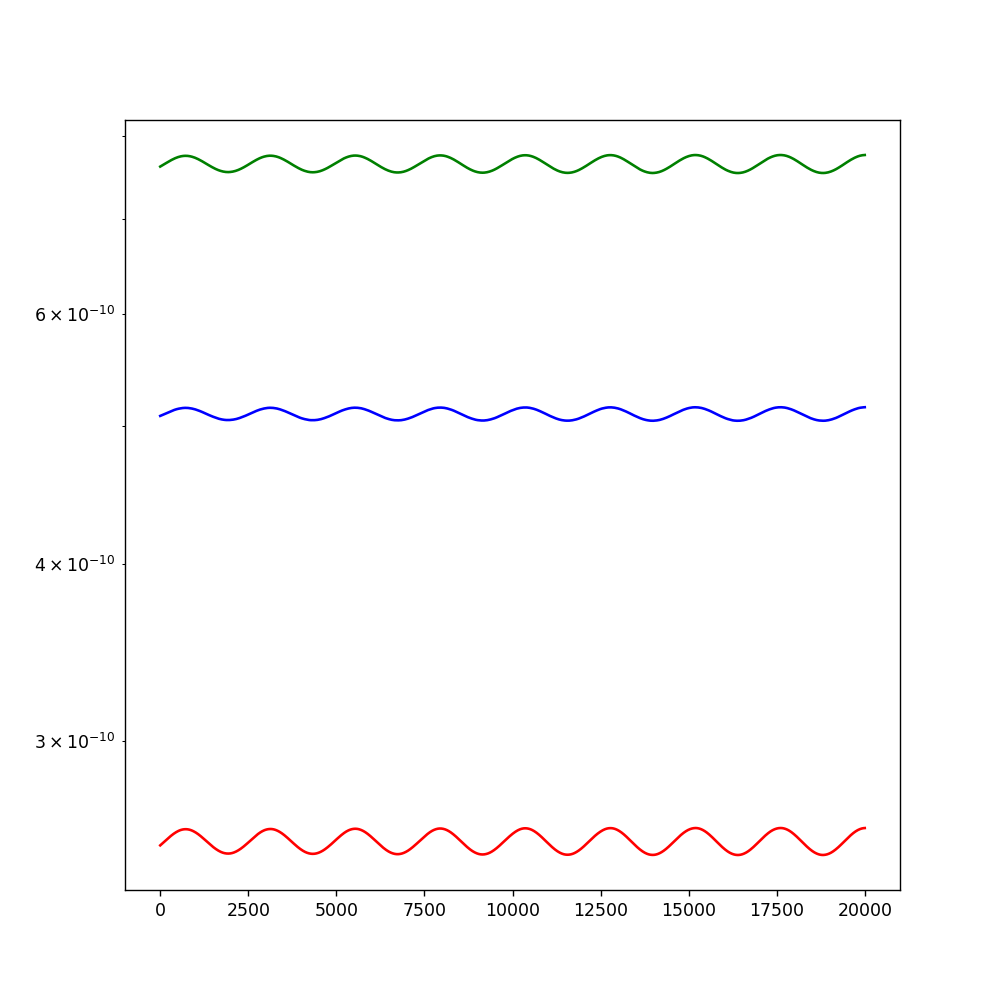

<IPython.core.display.Javascript object>


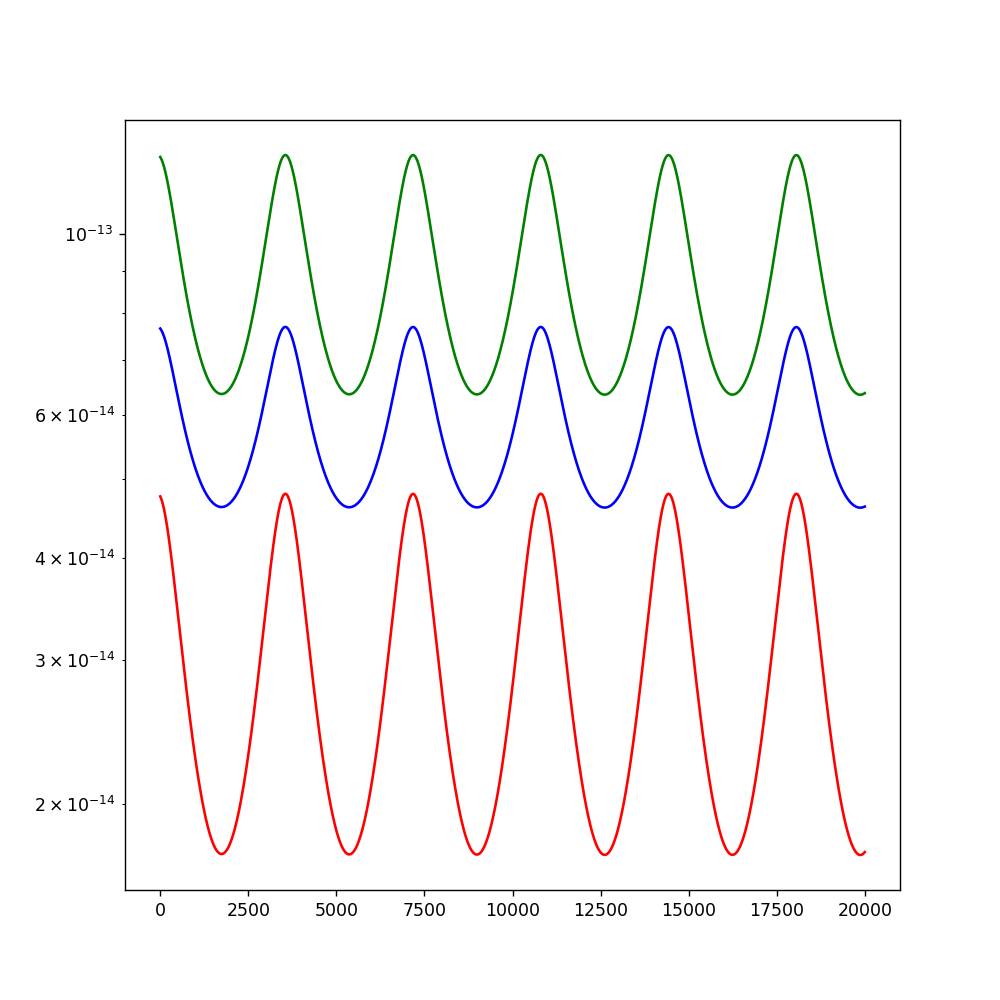

In [6]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(projection='3d')

ax = fig.gca()
ax.plot(qStored[-1][0][0], qStored[-1][0][1], qStored[-1][0][2], color = 'red', marker = 'o', markersize=10)
for j in range(1, numObjs):
    ax.plot(qStored[-1][j][0], qStored[-1][j][1], qStored[-1][j][2], color = 'blue', marker = '.', markersize=5)

ax.plot(qStored[:,0,0], qStored[:,0,1], qStored[:,0,2], color = 'red', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
for j in range(1, numObjs):
    ax.plot(qStored[:,j,0], qStored[:,j,1], qStored[:,j,2], color = 'blue', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)

# ax.set_xlim(-30,30)
# ax.set_ylim(-30,30)
# ax.set_zlim(-30,30)
# plt.savefig('Orbits.svg', dpi=2400)
#----------------------------------------------------------------------------------------------
# fig = plt.figure(figsize=(8, 8))
# ax = fig.gca()
plotStepSize = 1

energies = np.empty((numberTimeSteps,numObjs,2))
energies[:] = np.nan

for i in range(numberTimeSteps):
    for j in range(numObjs):
        energies[i,j,0] = (0.5 / masses[j]) * (pStored[i,j,0]**2 + pStored[i,j,1]**2 + pStored[i,j,2]**2)
        
        gravE = 0.0
        for k in range(numObjs):
            if (k != j):
                interObjDir = qStored[i,j] - qStored[i,k]
                gravE += 2.95912208286e-4 * masses[j] * masses[k] / (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**0.5
        
        energies[i,j,1] = gravE

for i in range(numObjs):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.plot(range(0,numberTimeSteps-1,plotStepSize), energies[0:-1:plotStepSize,i,0], color = 'red', marker = '', linestyle='-')
    ax.plot(range(0,numberTimeSteps-1,plotStepSize), energies[0:-1:plotStepSize,i,1], color = 'blue', marker = '', linestyle='-')
    ax.plot(range(0,numberTimeSteps-1,plotStepSize), energies[0:-1:plotStepSize,i,0] + energies[0:-1:plotStepSize,i,1], color = 'green', marker = '', linestyle='-')
    ax.set_yscale('log')

<IPython.core.display.Javascript object>


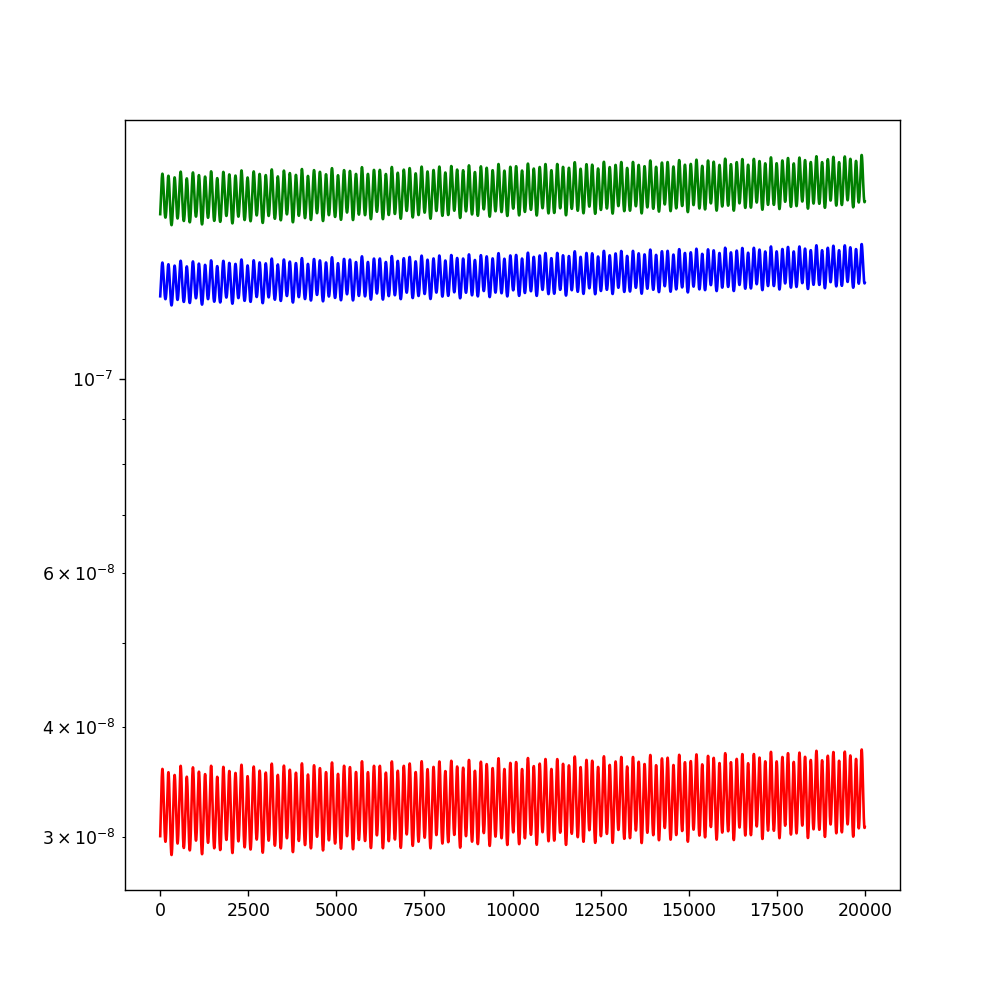

<IPython.core.display.Javascript object>


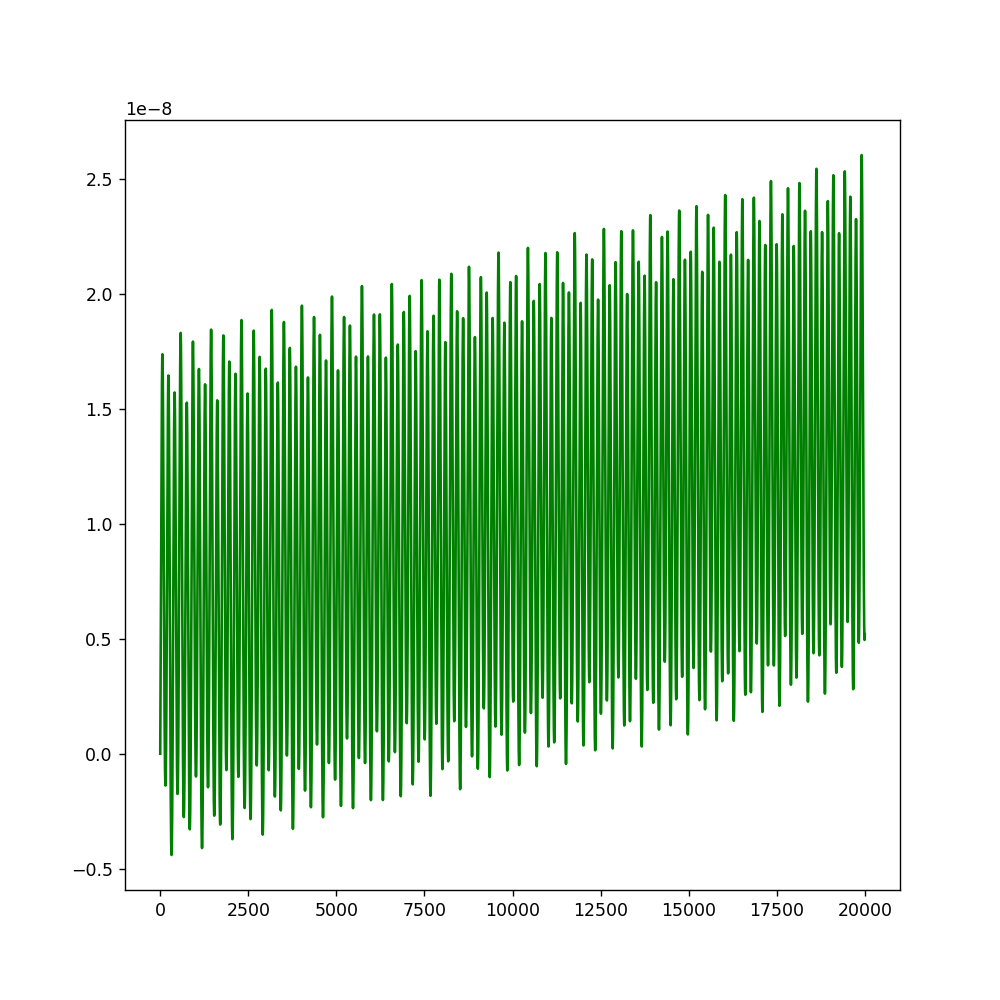

In [7]:
plotStepSize = 1
sysEnergies = energies.sum(axis = 1)
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.plot(range(0,numberTimeSteps-1,plotStepSize), sysEnergies[0:-1:plotStepSize,0], color = 'red', marker = '', linestyle='-')
ax.plot(range(0,numberTimeSteps-1,plotStepSize), sysEnergies[0:-1:plotStepSize,1], color = 'blue', marker = '', linestyle='-')
ax.plot(range(0,numberTimeSteps-1,plotStepSize), sysEnergies[0:-1:plotStepSize,0] + sysEnergies[0:-1:plotStepSize,1], color = 'green', marker = '', linestyle='-')
ax.set_yscale('log')

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.plot(range(0,numberTimeSteps-1,plotStepSize), (sysEnergies[0:-1:plotStepSize,0] + sysEnergies[0:-1:plotStepSize,1]) - (sysEnergies[0,0] + sysEnergies[0,1]), color = 'green', marker = '', linestyle='-')